https://www.kaggle.com/code/samfc10/handwriting-recognition-using-crnn-in-keras

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [2]:
train = pd.read_csv('C:/Users/pyotr/Desktop/homework folder but actually/research/dataset handwriting/written_name_train_v2.csv')
valid = pd.read_csv('C:/Users/pyotr/Desktop/homework folder but actually/research/dataset handwriting/written_name_validation_v2.csv')

In [3]:
train.head()

FILENAME   IDENTITY
0  TRAIN_00001.jpg  BALTHAZAR
1  TRAIN_00002.jpg      SIMON
2  TRAIN_00003.jpg      BENES
3  TRAIN_00004.jpg    LA LOVE
4  TRAIN_00005.jpg     DAPHNE

In [4]:
valid.head()

FILENAME    IDENTITY
0  VALIDATION_0001.jpg       BILEL
1  VALIDATION_0002.jpg  LAUMIONIER
2  VALIDATION_0003.jpg         LEA
3  VALIDATION_0004.jpg   JEAN-ROCH
4  VALIDATION_0005.jpg        RUPP

### Drop missing value

In [5]:
train=train.dropna()
valid=valid.dropna()

In [6]:
train.isnull().sum()

FILENAME    0
IDENTITY    0
dtype: int64

In [7]:
valid.isnull().sum()

FILENAME    0
IDENTITY    0
dtype: int64

data preprocessing

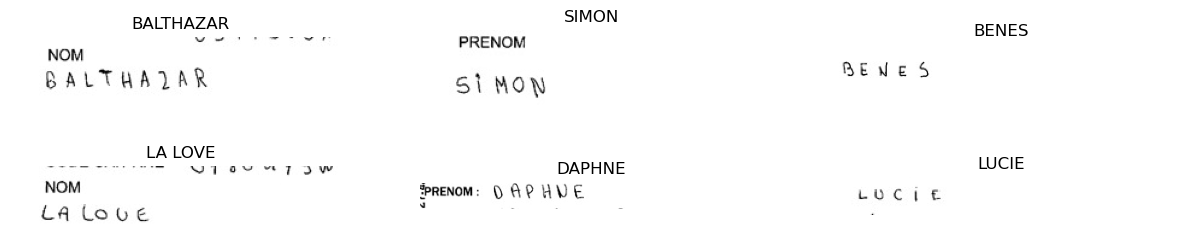

In [8]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/dataset handwriting/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

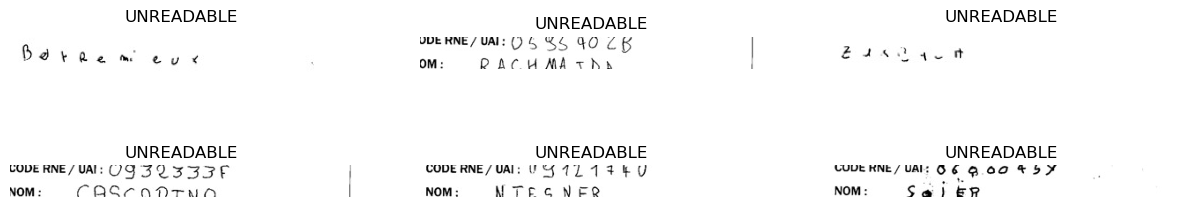

In [9]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/dataset handwriting/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [10]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [11]:
#uppercasing
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [12]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

Text(0.5, 1.0, 'NILS')

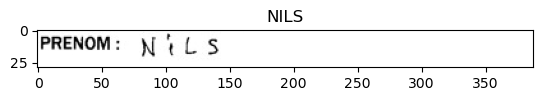

In [17]:
i=100000

img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/dataset handwriting/train_v2/train/'+train.loc[i, 'FILENAME']
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap = 'gray')
plt.title(train.loc[i, 'IDENTITY'], fontsize=12)

## Preprocessing and preparing the images for training

- The images are loaded as grayscale and reshaped to width 256 and height 64.
- The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y).
- The image is then normalized to range [0, 1]

In [ ]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [ ]:
train_size = 100000
valid_size = 10000

In [ ]:
train_x = []

for i in range(train_size):
    img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/dataset handwriting/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [ ]:
valid_x = []

for i in range(valid_size):
    img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/dataset handwriting/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [ ]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

## Preparing the labels for CTC Loss

https://sid2697.github.io/Blog_Sid/algorithm/2019/10/19/CTC-Loss.html#:~:text=Connectionist%20Temporal%20Classification%20(CTC)%20is,the%20training%20process%20more%20straightforward.

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (- ' and space).

In [ ]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 34 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for i in label:
        label_num.append(alphabets.find(i))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for i in num:
        if i == -1:
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

- train_y contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len.
- train_label_len contains the length of each true label (without padding)
- train_input_len contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.
- train_output is a dummy output for ctc loss.

In [ ]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [ ]:
index=100

print('True label : ',train.loc[index, 'IDENTITY'] , '\ntrain_y : ',train_y[index],
      '\ntrain_label_len : ',train_label_len[index], 
      '\ntrain_input_len : ', train_input_len[index])

In [ ]:
print(type(train_input_len))
print(type(train_y))

# modelling

In [ ]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, 3, padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, 3, padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, 3, padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

In [ ]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    #we put 2 here because the early outputs for RNN is usually poor
    y_pred = y_pred[:, 2:, :] 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

## Training

In [ ]:
model.load_weights('handwritingModel')

## Validation

In [ ]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
print(preds[0])
print(decoded[0])
print(prediction[1])


In [ ]:
actual = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = actual[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

# Evaluation Matrices

In [ ]:
import statistics

actual = valid.loc[:valid_size, 'IDENTITY']
correct = 0

accuracy=[]

for i in range(valid_size):
    pr = prediction[i]
    tr = actual[i]
    
    prdchar=0
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            prdchar += 1
        
    accuracy.append((prdchar/len(tr))*100)
    
    if pr == tr :
        correct += 1 
        
print('Correct characters predicted : %.2f%%' %(statistics.mean(accuracy)))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

In [ ]:
plt.hist(accuracy)

In [ ]:
acceptable=[x for x in accuracy if x >= 80]
print('Probability of good results : %.2f%%' %(len(acceptable)*100/len(accuracy)))

print('Median Accuracy : %.2f%%' %(statistics.median(accuracy)))

Accuracy = metrics.accuracy_score(actual, predicted)

# Examples

In [ ]:
test = pd.read_csv('C:/Users/pyotr/Desktop/homework folder but actually/research/dataset handwriting/written_name_test_v2.csv')

plt.figure(figsize=(10, 3))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/dataset handwriting/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    

In [ ]:
plt.figure(figsize=(7, 4))


ax = plt.subplot(1,1,1)
img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/image 7.png'
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                   greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')

In [ ]:
ax = plt.subplot(1,1,1)
img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/test font.png'
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                   greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')

In [ ]:
plt.figure(figsize=(7, 4))


ax = plt.subplot(1,1,1)
img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/cursive.png'
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                   greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/test/pen/'+str(i)+'.png'
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')


In [ ]:
plt.figure(figsize=(15, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/test/Friends/'+str(i)+'.png'
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=20)
    plt.axis('off')

# samples

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/test/1 Regular/'+str(i)+'.png'
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=20)
    plt.axis('off')

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/test/2 Disoriented/'+str(i)+'.png'
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=20)
    plt.axis('off')

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(2):
    ax = plt.subplot(2, 2, i+1)
    img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/test/3 Cursive/'+str(i)+'.png'
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=20)
    plt.axis('off')

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(3):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/test/4 capital/'+str(i)+'.png'
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=20)
    plt.axis('off')

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(2):
    ax = plt.subplot(2, 2, i+1)
    img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/test/5 Number/'+str(i)+'.png'
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=20)
    plt.axis('off')

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(3):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:/Users/pyotr/Desktop/homework folder but actually/research/test/6 non alphanumeric/'+str(i)+'.png'
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=20)
    plt.axis('off')